In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# model building
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout
from keras import layers
from tensorflow.keras import callbacks

# time series methods
from statsmodels.tsa.statespace.tools import diff

2022-03-08 16:18:57.160185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-08 16:18:57.160315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Read in cleaned data

In [3]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [4]:
df = pd.read_csv("../raw_data/bike_theft_cleaned.csv")

- No need for padding/masking here, as the sequences are of equal length 

# Group Dataframe by date and LOR

In [5]:
# Group dataframe by date and LOR
df_theft_model = df.pivot_table(index = "date_reported", columns = "Bezirk", values = "type_bike", aggfunc= "count")

df_theft_model.fillna(value = 0, inplace=True)

In [6]:
# create "total" column which sums up data for each day
df_theft_model["total"] = df_theft_model.sum(axis=1)

df_theft_model.shape

(424, 13)

In [7]:
df_theft_model.head()

Bezirk,1,2,3,4,5,6,7,8,9,10,11,12,total
date_reported,,,,,,,,,,,,,
2021-01-01,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0
2021-01-02,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,7.0
2021-01-03,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
2021-01-04,2.0,1.0,4.0,4.0,0.0,3.0,2.0,0.0,1.0,1.0,1.0,2.0,21.0
2021-01-05,6.0,4.0,5.0,7.0,0.0,0.0,5.0,1.0,1.0,0.0,1.0,1.0,31.0


# Build a baseline model predicting total of stolen bikes

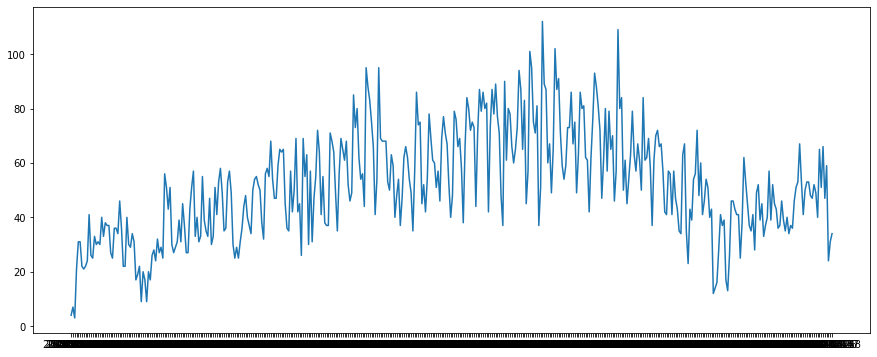

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(df_theft_model["total"]);

## Create Train and Test Dataset

In [10]:
len(df_theft_model)

424

In [11]:
len_ = int(len(df_theft_model)*0.8)
len_

339

In [12]:
df_train = df_theft_model["total"][:len_]

In [13]:
df_test = df_theft_model["total"][len_:]

In [14]:
df_test.shape

(85,)

## Create Training and Test Arrays

In [16]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset[i + window_size: i + window_size + future_horizon])

  return np.array(X), np.array(y)

In [17]:
window_size = 31
future_horizon = 1

X_train, y_train = get_X_y(window_size,future_horizon, df_train)
X_test, y_test = get_X_y(window_size, future_horizon, df_test)

In [18]:
X_train.shape

(307, 31)

In [19]:
X_test.shape

(53, 31)

In [20]:
X_test = np.expand_dims(X_test, 2)
X_train = np.expand_dims(X_train, 2)

In [21]:
X_train.shape

(307, 31, 1)

In [22]:
X_test.shape

(53, 31, 1)

## Baseline model

In [84]:
# create empty dictionary to save the model results
models_dict = dict()

Baseline model: last observation

In [23]:
y_pred_base = X_test[:,-1]
y_pred_base.shape

(53, 1)

In [24]:
type(y_pred_base)

numpy.ndarray

In [25]:
type(y_test)

numpy.ndarray

In [26]:
mean_absolute_percentage_error(y_test, y_pred_base)*100

21.743157887296032

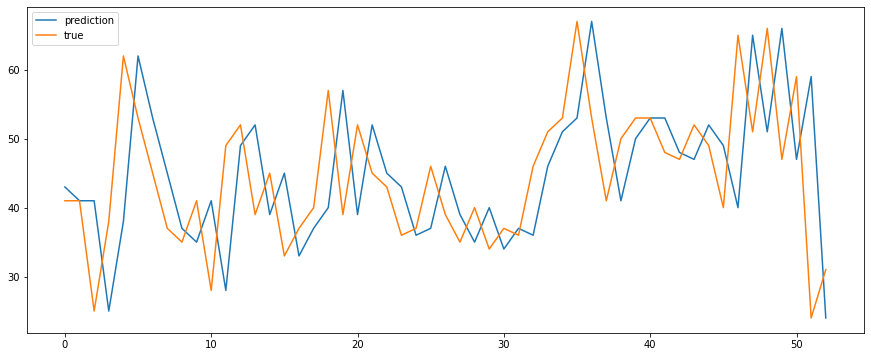

In [27]:
plt.figure(figsize = (15,6))
plt.plot(y_pred_base, label = "prediction")
plt.plot(y_test, label = "true")
plt.legend();

In [86]:
models_dict["baseline_model"] = {"model_description": "Baseline model, last observation", 
                                "MAPE": mean_absolute_percentage_error(y_test, y_pred_base)*100}

## KFold Cross-Validation

In [109]:
from sklearn.model_selection import KFold

def model_cross_validation(model):
    model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")
    
    results = []
    kf = KFold(n_splits = 5)
    kf.get_n_splits(X_train)

    for train_index, test_index in kf.split(X_train):

        # split the data into train and test set
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]

        model = model 
        
        # Fit the model
        model.fit(X_train_cv, y_train_cv, batch_size = 16, epochs = 300, verbose = 0)
        
        # Evaluate the model on the test data
        results.append(model.evaluate(X_test_cv, y_test_cv))
        
    return results

## Base model with just one dense layer

In [266]:
X_train.shape

(307, 31, 1)

In [52]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])

In [54]:
base_model_cv_results = model_cross_validation(base_model)

2/2 [==============================] - 0s 3ms/step - loss: 124.3003 - mean_absolute_percentage_error: 16.2282


In [87]:
np.mean(base_model_cv_results, axis = 0)[1]

17.356696701049806

In [62]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 31)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [88]:
models_dict["base_model"] ={"model_description": "just one dense layer",
                            "model_summary": base_model, 
                            "MAPE" : np.mean(base_model_cv_results, axis = 0)[1]}

In [89]:
models_dict

{'baseline_model': {'model_description': 'Baseline model, last observation',
  'MAPE': 27.97436259331299},
 'base_model': {'model_description': 'just one dense layer',
  'model_summary': <keras.engine.sequential.Sequential at 0x7fe734f0eb20>,
  'MAPE': 17.356696701049806}}

In [90]:
pd.DataFrame.from_dict(models_dict)

,baseline_model,base_model
model_description,"Baseline model, last observation",just one dense layer
MAPE,27.974363,17.356697
model_summary,NaN,<keras.engine.sequential.Sequential object at ...


In [203]:
base_model.

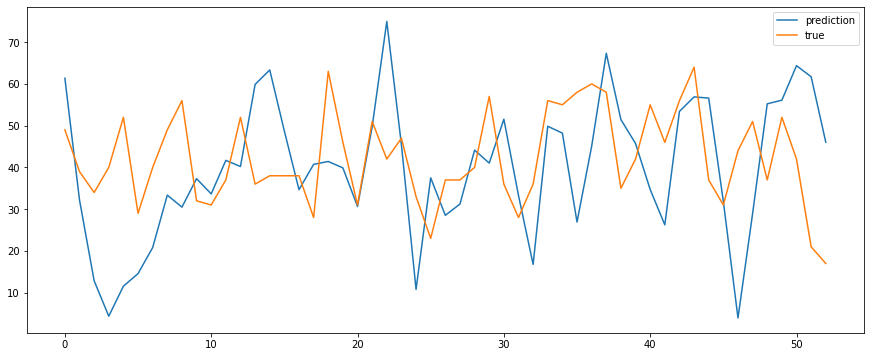

In [202]:
plt.figure(figsize = (15,6))
plt.plot(base_model.predict(X_test), label = "prediction")
plt.plot(y_test, label = "true")
plt.legend();

## Simple RNN model

In [91]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [104]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units = 10, activation = "tanh", input_shape = X_train.shape[1:]))
rnn_model.add(Dense(1, activation = "linear"))

In [105]:
rnn_model_cv_results = model_cross_validation(rnn_model)

2/2 [==============================] - 0s 4ms/step - loss: 160.3777 - mean_absolute_percentage_error: 18.6283


In [106]:
np.mean(rnn_model_cv_results, axis=0)

array([150.17118073,  22.10684052])

In [107]:
models_dict["one level RNN"] = {"model_description": "one simple RNN Layer with 10 units, one dense output layer",
                               "model_summary": rnn_model, 
                               "MAPE": np.mean(rnn_model_cv_results, axis=0)[1]}

In [108]:
pd.DataFrame.from_dict(models_dict)

,baseline_model,base_model,one level RNN
model_description,"Baseline model, last observation",just one dense layer,"one simple RNN Layer with 10 units, one dense ..."
MAPE,27.974363,17.356697,22.106841
model_summary,NaN,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...


## Deep RNN

In [114]:
deep_rnn = Sequential([
    SimpleRNN(20, activation = "tanh", return_sequences = True, input_shape = X_train.shape[1:]),
    SimpleRNN(20, activation = "tanh", return_sequences = False),
    Dense(1, activation = "linear")
])

In [115]:
deep_rnn_cv_results = model_cross_validation(deep_rnn)

2/2 [==============================] - 0s 5ms/step - loss: 137.4257 - mean_absolute_percentage_error: 16.5881


In [116]:
deep_rnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 31, 20)            440       
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 20)                820       
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [117]:
np.mean(deep_rnn_cv_results, axis=0)

array([143.64427032,  20.78903675])

In [118]:
models_dict["deep RNN"] = {"model_description": "two simple RNN layers with 20 units each",
                               "model_summary": deep_rnn, 
                               "MAPE": np.mean(deep_rnn_cv_results, axis=0)[1]}

In [119]:
pd.DataFrame.from_dict(models_dict)

,baseline_model,base_model,one level RNN,deep RNN
model_description,"Baseline model, last observation",just one dense layer,"one simple RNN Layer with 10 units, one dense ...",two simple RNN layers with 20 units each
MAPE,27.974363,17.356697,22.106841,20.789037
model_summary,NaN,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...


## Simple LSTM Model

In [120]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=10, activation='tanh', input_shape = X_train.shape[1:]))
lstm_model.add(Dense(1, activation="linear"))

In [121]:
lstm_model_cv_results = model_cross_validation(lstm_model)

2/2 [==============================] - 0s 4ms/step - loss: 140.6490 - mean_absolute_percentage_error: 17.2392


In [122]:
lstm_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [123]:
np.mean(lstm_model_cv_results, axis=0)

array([151.11899872,  23.04013958])

In [124]:
models_dict["simple LSTM"] = {"model_description": "one LSTM layer with 10 units",
                               "model_summary": lstm_model, 
                               "MAPE": np.mean(lstm_model_cv_results, axis=0)[1]}

In [125]:
pd.DataFrame.from_dict(models_dict)

,baseline_model,base_model,one level RNN,deep RNN,simple LSTM
model_description,"Baseline model, last observation",just one dense layer,"one simple RNN Layer with 10 units, one dense ...",two simple RNN layers with 20 units each,one LSTM layer with 10 units
MAPE,27.974363,17.356697,22.106841,20.789037,23.04014
model_summary,NaN,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...


## GRU Model

In [126]:
gru_model = Sequential()
gru_model.add(GRU(units=10, activation='tanh', input_shape = X_train.shape[1:]))
gru_model.add(Dense(1, activation="linear"))

In [127]:
gru_model_cv_results = model_cross_validation(gru_model)

2/2 [==============================] - 0s 4ms/step - loss: 147.7572 - mean_absolute_percentage_error: 17.1797


In [128]:
gru_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10)                390       
                                                                 
 dense_8 (Dense)             (None, 1)                 11        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [129]:
np.mean(gru_model_cv_results, axis=0)

array([145.08535309,  21.89199314])

In [130]:
models_dict["simple GRU"] = {"model_description": "one GRU layer with 10 units",
                               "model_summary": gru_model, 
                               "MAPE": np.mean(gru_model_cv_results, axis=0)[1]}

In [131]:
pd.DataFrame.from_dict(models_dict)

,baseline_model,base_model,one level RNN,deep RNN,simple LSTM,simple GRU
model_description,"Baseline model, last observation",just one dense layer,"one simple RNN Layer with 10 units, one dense ...",two simple RNN layers with 20 units each,one LSTM layer with 10 units,one GRU layer with 10 units
MAPE,27.974363,17.356697,22.106841,20.789037,23.04014,21.891993
model_summary,NaN,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...


## Conclusion of cross validation

In [301]:
!pwd

/home/jakob/code/hmichinaka/berlin-bike-theft-forecasting/notebooks


In [305]:
pd.DataFrame.from_dict(models_dict)

,baseline_model,base_model,one level RNN,deep RNN,simple LSTM,simple GRU
model_description,"Baseline model, last observation",just one dense layer,"one simple RNN Layer with 10 units, one dense ...",two simple RNN layers with 20 units each,one LSTM layer with 10 units,one GRU layer with 10 units
MAPE,27.974363,17.356697,22.106841,20.789037,23.04014,21.891993
model_summary,NaN,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...,<keras.engine.sequential.Sequential object at ...


Out of the different model archictectures we looked at, the deep RNN with tow RNN layers seem to work fine.
The next step is to finetune that archictecture by adding dropout layers or changing the number of units in each layer. 

The MAPE varies widely during the cross-validation. This might indicate that the dataset is too small for a proper cross-validation. We will thus in the next step train the models on the whole dataset. 

# Fit models on whole dataset

In [141]:
base_model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(1)
])

base_model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")

base_model.fit(X_train, 
          y_train,
        epochs= 300,
         batch_size = 16, 
         validation_split=0.2,


Epoch 1/300
16/16 [==============================] - 0s 6ms/step - loss: 1057.6799 - mean_absolute_percentage_error: 49.2560 - val_loss: 598.0759 - val_mean_absolute_percentage_error: 30.6212
Epoch 2/300
16/16 [==============================] - 0s 2ms/step - loss: 375.9853 - mean_absolute_percentage_error: 30.9294 - val_loss: 576.9699 - val_mean_absolute_percentage_error: 33.7741
Epoch 3/300
16/16 [==============================] - 0s 2ms/step - loss: 360.6513 - mean_absolute_percentage_error: 31.1845 - val_loss: 590.3259 - val_mean_absolute_percentage_error: 34.1411
Epoch 4/300
16/16 [==============================] - 0s 2ms/step - loss: 349.6883 - mean_absolute_percentage_error: 30.7423 - val_loss: 532.7872 - val_mean_absolute_percentage_error: 32.6385
Epoch 5/300
16/16 [==============================] - 0s 2ms/step - loss: 343.8350 - mean_absolute_percentage_error: 30.3829 - val_loss: 520.0998 - val_mean_absolute_percentage_error: 32.2729
Epoch 6/300
16/16 [=========================

In [142]:
base_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 2ms/step - loss: 346.4644 - mean_absolute_percentage_error: 39.8687


[346.4644470214844, 39.86869812011719]

In [136]:
model = Sequential([
    SimpleRNN(20, activation = "tanh", return_sequences = True, input_shape = X_train.shape[1:]),
    SimpleRNN(20, activation = "tanh", return_sequences = False),
    Dense(1, activation = "linear")
])

model.compile(loss = "mse",
                 optimizer = "adam",
                 metrics = "mean_absolute_percentage_error")

model.fit(X_train, 
          y_train,
        epochs= 300,
         batch_size = 16, 
         validation_split=0.2,
         callbacks=[es])
model.evaluate(X_test, y_test)

Epoch 1/300
16/16 [==============================] - 1s 20ms/step - loss: 3108.1042 - mean_absolute_percentage_error: 95.2695 - val_loss: 3838.1194 - val_mean_absolute_percentage_error: 94.8858
Epoch 2/300
16/16 [==============================] - 0s 11ms/step - loss: 2951.8936 - mean_absolute_percentage_error: 92.1013 - val_loss: 3666.2837 - val_mean_absolute_percentage_error: 92.5270
Epoch 3/300
16/16 [==============================] - 0s 11ms/step - loss: 2802.7520 - mean_absolute_percentage_error: 89.0152 - val_loss: 3526.8069 - val_mean_absolute_percentage_error: 90.5676
Epoch 4/300
16/16 [==============================] - 0s 11ms/step - loss: 2719.2297 - mean_absolute_percentage_error: 87.2893 - val_loss: 3458.6338 - val_mean_absolute_percentage_error: 89.5978
Epoch 5/300
16/16 [==============================] - 0s 10ms/step - loss: 2667.2720 - mean_absolute_percentage_error: 86.1386 - val_loss: 3403.5315 - val_mean_absolute_percentage_error: 88.8044
Epoch 6/300
16/16 [===========

16/16 [==============================] - 0s 11ms/step - loss: 1615.8599 - mean_absolute_percentage_error: 61.6441 - val_loss: 2151.0198 - val_mean_absolute_percentage_error: 68.4946
Epoch 44/300
16/16 [==============================] - 0s 11ms/step - loss: 1594.7595 - mean_absolute_percentage_error: 61.1729 - val_loss: 2125.3538 - val_mean_absolute_percentage_error: 68.0193
Epoch 45/300
16/16 [==============================] - 0s 11ms/step - loss: 1573.9003 - mean_absolute_percentage_error: 60.6768 - val_loss: 2099.9126 - val_mean_absolute_percentage_error: 67.5451
Epoch 46/300
16/16 [==============================] - 0s 11ms/step - loss: 1553.7562 - mean_absolute_percentage_error: 60.1621 - val_loss: 2073.9358 - val_mean_absolute_percentage_error: 67.0576
Epoch 47/300
16/16 [==============================] - 0s 11ms/step - loss: 1533.2670 - mean_absolute_percentage_error: 59.6864 - val_loss: 2048.4104 - val_mean_absolute_percentage_error: 66.5754
Epoch 48/300
16/16 [==================

16/16 [==============================] - 0s 11ms/step - loss: 550.2144 - mean_absolute_percentage_error: 33.9250 - val_loss: 750.6262 - val_mean_absolute_percentage_error: 35.7107
Epoch 128/300
16/16 [==============================] - 0s 10ms/step - loss: 544.4356 - mean_absolute_percentage_error: 33.0016 - val_loss: 740.5613 - val_mean_absolute_percentage_error: 35.4381
Epoch 129/300
16/16 [==============================] - 0s 11ms/step - loss: 530.2561 - mean_absolute_percentage_error: 32.4408 - val_loss: 730.8711 - val_mean_absolute_percentage_error: 35.1750
Epoch 130/300
16/16 [==============================] - 0s 10ms/step - loss: 522.2982 - mean_absolute_percentage_error: 31.8812 - val_loss: 721.1824 - val_mean_absolute_percentage_error: 34.9090
Epoch 131/300
16/16 [==============================] - 0s 11ms/step - loss: 515.5836 - mean_absolute_percentage_error: 31.0785 - val_loss: 711.6317 - val_mean_absolute_percentage_error: 34.6448
Epoch 132/300
16/16 [=======================

16/16 [==============================] - 0s 11ms/step - loss: 214.0849 - mean_absolute_percentage_error: 20.6259 - val_loss: 268.7118 - val_mean_absolute_percentage_error: 21.4490
Epoch 212/300
16/16 [==============================] - 0s 11ms/step - loss: 211.7849 - mean_absolute_percentage_error: 20.2869 - val_loss: 265.7372 - val_mean_absolute_percentage_error: 21.3668
Epoch 213/300
16/16 [==============================] - 0s 11ms/step - loss: 210.7761 - mean_absolute_percentage_error: 20.5843 - val_loss: 269.1149 - val_mean_absolute_percentage_error: 21.1731
Epoch 214/300
16/16 [==============================] - 0s 11ms/step - loss: 213.4933 - mean_absolute_percentage_error: 20.7948 - val_loss: 257.8557 - val_mean_absolute_percentage_error: 21.1868
Epoch 215/300
16/16 [==============================] - 0s 11ms/step - loss: 205.9973 - mean_absolute_percentage_error: 20.4271 - val_loss: 257.4234 - val_mean_absolute_percentage_error: 21.0053
Epoch 216/300
16/16 [=======================

16/16 [==============================] - 0s 11ms/step - loss: 124.6348 - mean_absolute_percentage_error: 17.3697 - val_loss: 148.4116 - val_mean_absolute_percentage_error: 16.2975
Epoch 296/300
16/16 [==============================] - 0s 11ms/step - loss: 123.6548 - mean_absolute_percentage_error: 17.3218 - val_loss: 148.0864 - val_mean_absolute_percentage_error: 16.3053
Epoch 297/300
16/16 [==============================] - 0s 11ms/step - loss: 123.1533 - mean_absolute_percentage_error: 17.1673 - val_loss: 147.6823 - val_mean_absolute_percentage_error: 16.3278
Epoch 298/300
16/16 [==============================] - 0s 11ms/step - loss: 123.8944 - mean_absolute_percentage_error: 17.1888 - val_loss: 147.2140 - val_mean_absolute_percentage_error: 16.3393
Epoch 299/300
16/16 [==============================] - 0s 11ms/step - loss: 124.0618 - mean_absolute_percentage_error: 17.4159 - val_loss: 147.3242 - val_mean_absolute_percentage_error: 16.2917
Epoch 300/300
2/2 [=========================

[134.50564575195312, 26.728870391845703]

In [140]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 8ms/step - loss: 134.5056 - mean_absolute_percentage_error: 26.7289


[134.50564575195312, 26.728870391845703]

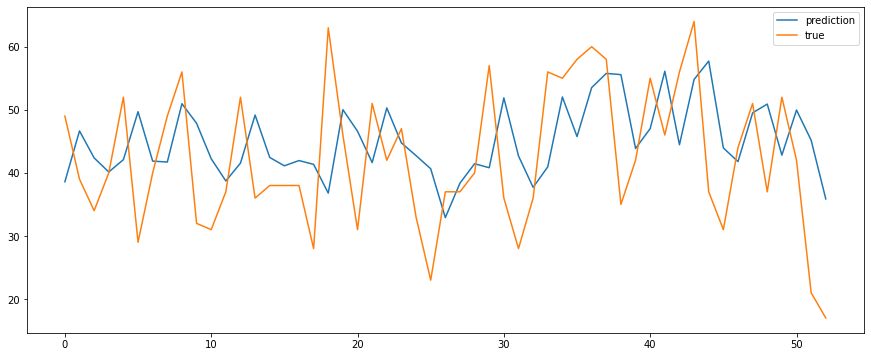

In [195]:
y_pred = model.predict(X_test)

plt.figure(figsize = (15,6))
plt.plot(y_pred, label = "prediction")
plt.plot(y_test, label = "true")
plt.legend();

## Second (more complex) RNN model

In [192]:
rnn_model_2 = Sequential()
# first LSTM layer
rnn_model_2.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
rnn_model_2.add(Dropout(0.3))
# second LSTM layer
#rnn_model_2.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
rnn_model_2.add(LSTM(units= 10, activation= "tanh", return_sequences= False))
rnn_model_2.add(Dropout(0.3))

# output layer to predict one value
rnn_model_2.add(Dense(1, activation= "linear"))

rnn_model_2.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")

history = rnn_model_2.fit(X_train, 
                        y_train,
          batch_size=8, 
          epochs=300,
          validation_split=0.2,
          callbacks=[es], verbose = 0)

In [193]:
rnn_model_2.evaluate(X_test, y_test)

2/2 [==============================] - 0s 6ms/step - loss: 139.1081 - mean_absolute_percentage_error: 25.7753


[139.10813903808594, 25.77528953552246]

In [185]:
y_pred_rnn_2 = rnn_model_2.predict(X_test)

In [187]:
mean_absolute_percentage_error(y_test, y_pred_rnn_2)*100

25.462162777085005

# Finetuning

def model_create_compile(n_units_1 = 50, n_units_2 = 10, dropout_rate = 0.2):
    model = Sequential()
    # first LSTM layer
    model.add(LSTM(units = n_units_1, activation = "tanh", return_sequences = True))
    model.add(Dropout(dropout_rate))
    # second LSTM layer
    model.add(LSTM(units= n_units_2, activation= "tanh", return_sequences= False))
    model.add(Dropout(dropout_rate))

    # output layer to predict one value
    model.add(Dense(1, activation= "linear"))

    model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")

    return model

es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, 
                y_train,
              batch_size=8, 
              epochs=300,
              validation_split=0.2,
              callbacks=[es], verbose = 1)

n_units_1 = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_units_2 = [10, 20, 30]
dropout_rate = [0.1, 0.2, 0.3] 

out = []

for i in n_units_1: 
    for j in n_units_2:
            for k in dropout_rate:
                out.append((i, j, k))

result = []

for n in out:
    temp = []
    n_units_1, n_units_2, dropout_rate = n
    model = model_create_compile(n_units_1= n_units_1, n_units_2= n_units_2, dropout_rate=dropout_rate)
    temp.append(n_units_1)
    temp.append(n_units_2)
    temp.append(dropout_rate)
    
    cv_result = model_cross_validation(model)
    temp.append(np.mean(model_cross_validation, axis = 0)[1]))
    
    result.append(temp)

    

# Finetuned Model

The grid search gives us the following optimal model architecture:

In [28]:
opt_model = Sequential()
# first LSTM layer
opt_model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
opt_model.add(Dropout(0.2))
# second LSTM layer
opt_model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
opt_model.add(Dropout(0.2))

# output layer to predict one value
opt_model.add(Dense(1, activation= "linear"))

opt_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")

2022-03-08 16:20:57.949513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-08 16:20:57.949613: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 16:20:57.949635: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-C0GM00LC): /proc/driver/nvidia/version does not exist
2022-03-08 16:20:57.950115: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

opt_model.fit(X_train, 
                y_train,
              batch_size=8, 
              epochs=300,
              validation_split=0.2,
              callbacks=[es], verbose = 1)

Epoch 1/300
31/31 [==============================] - 3s 33ms/step - loss: 3068.7781 - mean_absolute_percentage_error: 94.0870 - val_loss: 3809.5283 - val_mean_absolute_percentage_error: 92.4663
Epoch 2/300
31/31 [==============================] - 1s 17ms/step - loss: 2749.8645 - mean_absolute_percentage_error: 87.0832 - val_loss: 3525.8330 - val_mean_absolute_percentage_error: 88.5274
Epoch 3/300
31/31 [==============================] - 1s 17ms/step - loss: 2589.6782 - mean_absolute_percentage_error: 83.4009 - val_loss: 3390.5911 - val_mean_absolute_percentage_error: 86.5903
Epoch 4/300
31/31 [==============================] - 1s 17ms/step - loss: 2478.1958 - mean_absolute_percentage_error: 80.8904 - val_loss: 3273.6570 - val_mean_absolute_percentage_error: 84.8798
Epoch 5/300
31/31 [==============================] - 1s 17ms/step - loss: 2378.2402 - mean_absolute_percentage_error: 78.6548 - val_loss: 3151.6350 - val_mean_absolute_percentage_error: 83.0596
Epoch 6/300
31/31 [===========

31/31 [==============================] - 1s 18ms/step - loss: 689.6979 - mean_absolute_percentage_error: 37.9598 - val_loss: 913.4372 - val_mean_absolute_percentage_error: 37.8135
Epoch 44/300
31/31 [==============================] - 1s 18ms/step - loss: 652.7812 - mean_absolute_percentage_error: 37.1007 - val_loss: 886.6892 - val_mean_absolute_percentage_error: 37.0236
Epoch 45/300
31/31 [==============================] - 1s 20ms/step - loss: 628.2319 - mean_absolute_percentage_error: 36.5863 - val_loss: 860.1689 - val_mean_absolute_percentage_error: 36.2247
Epoch 46/300
31/31 [==============================] - 1s 18ms/step - loss: 629.0160 - mean_absolute_percentage_error: 37.3156 - val_loss: 835.5793 - val_mean_absolute_percentage_error: 35.4691
Epoch 47/300
31/31 [==============================] - 1s 17ms/step - loss: 623.7322 - mean_absolute_percentage_error: 36.8120 - val_loss: 810.6925 - val_mean_absolute_percentage_error: 34.6890
Epoch 48/300
31/31 [============================

31/31 [==============================] - 1s 18ms/step - loss: 334.5177 - mean_absolute_percentage_error: 28.7182 - val_loss: 345.3424 - val_mean_absolute_percentage_error: 21.5956
Epoch 86/300
31/31 [==============================] - 1s 18ms/step - loss: 308.7409 - mean_absolute_percentage_error: 29.1938 - val_loss: 337.6218 - val_mean_absolute_percentage_error: 21.3530
Epoch 87/300
31/31 [==============================] - 1s 18ms/step - loss: 313.5582 - mean_absolute_percentage_error: 27.3896 - val_loss: 329.9021 - val_mean_absolute_percentage_error: 21.1176
Epoch 88/300
31/31 [==============================] - 1s 19ms/step - loss: 308.6284 - mean_absolute_percentage_error: 27.2650 - val_loss: 323.7449 - val_mean_absolute_percentage_error: 20.9251
Epoch 89/300
31/31 [==============================] - 1s 18ms/step - loss: 288.2228 - mean_absolute_percentage_error: 26.6234 - val_loss: 317.3487 - val_mean_absolute_percentage_error: 20.7303
Epoch 90/300
31/31 [============================

31/31 [==============================] - 1s 18ms/step - loss: 238.7325 - mean_absolute_percentage_error: 24.8422 - val_loss: 217.4662 - val_mean_absolute_percentage_error: 18.6339
Epoch 128/300
31/31 [==============================] - 1s 18ms/step - loss: 221.4781 - mean_absolute_percentage_error: 23.9829 - val_loss: 216.9771 - val_mean_absolute_percentage_error: 18.6933
Epoch 129/300
31/31 [==============================] - 1s 18ms/step - loss: 230.5130 - mean_absolute_percentage_error: 24.7346 - val_loss: 215.7959 - val_mean_absolute_percentage_error: 18.6523
Epoch 130/300
31/31 [==============================] - 1s 18ms/step - loss: 233.9999 - mean_absolute_percentage_error: 24.3490 - val_loss: 216.3766 - val_mean_absolute_percentage_error: 18.7971
Epoch 131/300
31/31 [==============================] - 1s 17ms/step - loss: 221.2471 - mean_absolute_percentage_error: 23.1025 - val_loss: 213.6662 - val_mean_absolute_percentage_error: 18.5454
Epoch 132/300
31/31 [=======================

In [30]:
opt_model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 9ms/step - loss: 100.3756 - mean_absolute_percentage_error: 17.6241


[100.3756103515625, 17.624107360839844]

In [308]:
mean_squared_error(opt_model.predict(X_test), y_test, squared=False)

44.2905055781025

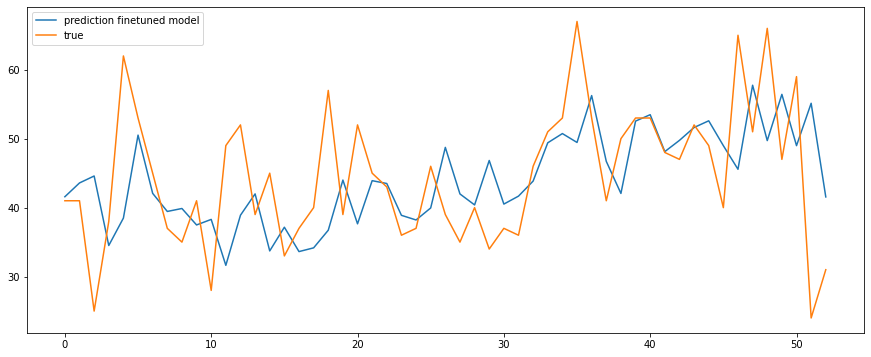

In [31]:
plt.figure(figsize = (15,6))
plt.plot(opt_model.predict(X_test), label = "prediction finetuned model")
#plt.plot(base_model.predict(X_test), label = "one dense layer model prediction")
plt.plot(y_test, label = "true")
plt.legend();

# Differenced Dataset

In [273]:
y_diff = df_theft_model["total"].diff(1).dropna()

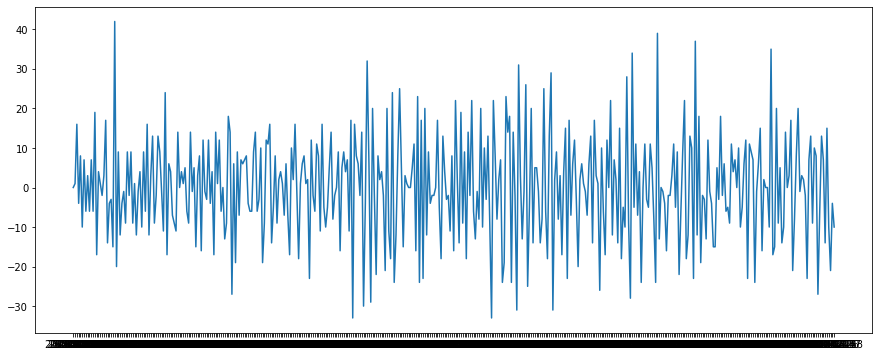

In [277]:
plt.figure(figsize=(15,6))
plt.plot(y_diff);

## Create training and test arrays out of the differenced dataset

In [282]:
int(len(y_diff) * 0.8)

338

In [283]:
y_diff_train = y_diff[:338]
y_diff_test = y_diff[338:]

In [ ]:
def get_X_y(window_size, future_horizon, dataset):

  X = []
  y = []

  for i in range(0, dataset.shape[0] - window_size - future_horizon):
    X.append(dataset[i: i + window_size])
    y.append(dataset[i + window_size: i + window_size + future_horizon])

  return np.array(X), np.array(y)

In [284]:
window_size = 31
future_horizon = 1

X_diff_train, y_diff_train = get_X_y(window_size,future_horizon, y_diff_train)
X_diff_test, y_diff_test = get_X_y(window_size, future_horizon, y_diff_test)

In [292]:
X_diff_train = np.expand_dims(X_diff_train, 2)
X_diff_test = np.expand_dims(X_diff_test, 2)

In [293]:
X_diff_train.shape, y_diff_train.shape, X_diff_test.shape, y_diff_test.shape

((306, 31, 1), (306, 1), (53, 31, 1), (53, 1))

## Rerun optimal model on differenced dataset

In [297]:
diff_model = Sequential()
# first LSTM layer
diff_model.add(LSTM(units = 70, activation = "tanh", return_sequences = True))
diff_model.add(Dropout(0.2))
# second LSTM layer
diff_model.add(LSTM(units= 30, activation= "tanh", return_sequences= False))
diff_model.add(Dropout(0.2))

# output layer to predict one value
diff_model.add(Dense(1, activation= "linear"))

diff_model.compile(optimizer= "adam", loss= "mse", metrics = "mean_absolute_percentage_error")

In [298]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

diff_model.fit(X_diff_train, 
                y_diff_train,
              batch_size=8, 
              epochs=300,
              validation_split=0.2,
              callbacks=[es], verbose = 1)

Epoch 1/300
31/31 [==============================] - 3s 36ms/step - loss: 172.9837 - mean_absolute_percentage_error: 5322897.5000 - val_loss: 185.1304 - val_mean_absolute_percentage_error: 8620484.0000
Epoch 2/300
31/31 [==============================] - 1s 19ms/step - loss: 167.7369 - mean_absolute_percentage_error: 7363249.5000 - val_loss: 178.7610 - val_mean_absolute_percentage_error: 51120060.0000
Epoch 3/300
31/31 [==============================] - 1s 18ms/step - loss: 157.9093 - mean_absolute_percentage_error: 17087048.0000 - val_loss: 168.8835 - val_mean_absolute_percentage_error: 80864952.0000
Epoch 4/300
31/31 [==============================] - 1s 18ms/step - loss: 150.0959 - mean_absolute_percentage_error: 34867732.0000 - val_loss: 163.3153 - val_mean_absolute_percentage_error: 121639832.0000
Epoch 5/300
31/31 [==============================] - 1s 20ms/step - loss: 145.6993 - mean_absolute_percentage_error: 46754996.0000 - val_loss: 160.2125 - val_mean_absolute_percentage_err

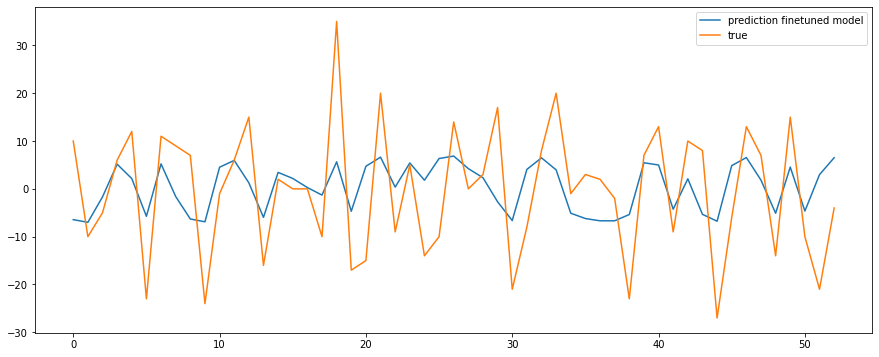

In [300]:
plt.figure(figsize = (15,6))
plt.plot(diff_model.predict(X_diff_test), label = "prediction finetuned model")
plt.plot(y_diff_test, label = "true")
plt.legend();



In [296]:
diff_model.evaluate(X_diff_test, y_diff_test)

2/2 [==============================] - 0s 8ms/step - loss: 141.2215 - mean_absolute_percentage_error: 80556208.0000


[141.22149658203125, 80556208.0]

In [307]:
mean_squared_error(y_diff_test, diff_model.predict(X_diff_test), squared=False)

11.732560160628768

# Normalized dataset